# V3: Effect of diversity of interests on GitHub team productivity

- NAME: ZHANG YIFAN
- STUDENT NUMBER: 1004245952

## Introduction

The purpose of the project is to analyze the effect of diversity of individual members on GitHub team productivity by using machine learning models. 


The core paper I select to develop this project on is **Diversity of editors and teams versus quality of cooperative work: experiments on Wikipedia** [1]. 
> The paper presents some empirical study towards understanding of the role of diversity in individual and whole teams on the quality of the article in open collaboration environment like Wikipedia. In this paper, M. Sydow et al proposed an original diversity measure to quantify the diversity of interests of editor in Wikipedia. The interest profile of each editor is defined as the interest distribution vector over the set of all categories. And the diversity of interests(or equivalently versatility) of the editor is defined as the entropy of interest profile.


Team diversity is one of the fundamental issues in social and organizational studies that has been broadly researched on. Open Source Software(OSS) projects on GitHub, like Wikipedia, is highly rely on collaboration and naturally embraced the diversity. It is interesting to study whether team members have diverse interests tend to be more productive in GitHub projects. 

In version one, in order to immigrate this approach on GitHub, I use the open dataset prepared by B. Vasilescu [2], which is contains the gender, location, domain and commit information of each committer in sperate GitHub projects. In this dataset, the language and domain can also reflect the interest of committers, so I select those two features to reproduce the approach as diversity of interests in Wikipedia. 

In version two, I collect data by using GHTorrent on Google BigQuery. The tables I selected are projects, project_member, commits in ght_2018_04_01. Then I identity the domain of the projects by Latent Dirichlet Allocation(LDA), a well-known topic analysis algorithm, on the text describing project features. The method is proposed in paper **A Large Scale Study of Programming Languages and Code Quality in GitHub**[3].


In both versions, I choose following features to analyze the effect of diversity of individual members on GitHub team productivity.

Firstly I calculate the domain versatility and language versatility for each committer and calculate the versatility for each projects. Similar to the main domain of the Wikipedia article, the domain of the Github projects could also reflect the interest of GitHub users. Also, mastering different programming languages can also reflect user interest in different fields. For example, language like HTML and CSS are related Frond End strongly, and language like python and R will be the first choice for data analysis.

For productivity, an indicator of successful Github project, I select commits number to quantify the productivity of GitHub teams according to Rajdeep[5]. 
>Software development teams use the Concurrent Versioning System (CVS) to manage the software development process. CVS enables teams to store source code at a central location, thus enabling team members to retrieve the source code to make changes. CVS also helps the team to keep track of every change, including what was changed, when it was changed, and who made
the change, and helps in blending changes made by different developers, including ensuring that developers do not accidentally overwrite each others’ alterations. A commit occurs when a developer uploads the altered source code file, where the CVS tool updates the changed files automatically. **As CVS commits reflect meaningful changes to the source code,
we treat the number of commits as an indicator of successful technical refinement.**

According to the core paper, I separate projects in terms of its team size and apply several machine learning algorithms and evaluate the relationship between diversity and productivity.

## Project Plan
### Version 1
- Literature Review (5h)
    - Search and read related influential papers and compare their techniques.
    - Writing literature review with references to the bibliography
- Paper Reproduce (8h)
    - Reproduce the results based on GitHub dataset equipped with domain and language
    - Apply machine learning algorithms and analyze the result

### Version 2
- Understand the structure of dataset from GHTorrent and fetch/filter data from Google BigQuery (2h)
- Processing the data (10h)
    - Need to separate projects into different domains. However, the domain field is not supported by GHTorrent. Therefore, I use Latent Dirichlet Allocation(LDA) to infer the domain of the projects and generate 10 domains for GitHub repositories.
    - Analyze the diversity of domain and languages in terms of each user/project
- Build the model (5h)
    - In the core paper, the dependent variable is the quality of article, which is a 5-level categorical variable. However in GitHub, there is no existed standard for quality of projects. So I decide to use the total commits as the indicator of project's productivity. And apply Linear Regression to GitHub dataset.
- Assess model (3h)
    - Evaluate the model by mse and predict the productivity on test dataset

### Version 3
- Review the project (2h)
    - Review the methods and results of the project: Using LDA from pyspark instead of gensim package.
    - Access the implementation of the projects, summarize the strength and weakness of the project
- Finish final report (4h)


## Date Understanding
### Filter data by using GHTorrent and Bigquery
The GHTorent project [4] uses GitHub API to collect more than 900GB of raw data and 10GB of metadata, which enables researchers to retrieve high-quality, interconnected data. The GHTorrent is currently available on Google Bigquery. The dataset we selected is ght_2018_04_01 from ghtorrent-bq. The table contains 83624114 records of GitHub repositories, and the tables we use in this project are projects, users, project_members, project_commits. Since some of Github repositories are not suitable for our analyzation, so I filter the projects by following standards. After filtering, we only select 59244 projects and saved as projects.csv. 

- Filter projects with created time before Oct 2017 and save as table [projects_filter], since projects created less than 90 days don't have sufficient data for analyzing diversity and commits.

In [ ]:
# SELECT id, name, description, language, created_at, updated_at,  FROM [ghtorrent-bq:ght_2018_04_01.projects] 
# HAVING (YEAR(created_at) < 2017 OR (YEAR(created_at) = 2017 AND MONTH(created_at) < 10))

- Drop inactive projects and save as table [commits] and join projects_filter as table [projects_commits]

In [ ]:
# SELECT project_id, COUNT(committer_id) total_commits FROM [ghtorrent-bq:ght_2018_04_01.commits]
# GROUP BY project_id
# HAVING total_commits > 10

In [ ]:
# SELECT id as pid, name, description, language, total_commits
# FROM [artest-7cda9:mie1512.projects_filter] as p
# INNER JOIN 
# (SELECT * FROM [artest-7cda9:mie1512.commits]) as c
# ON p.id = c.project_id

- Drop rows with incomplete information like(description and language)

In [ ]:
# SELECT * FROM [artest-7cda9:mie1512.projects_commits]
# WHERE description <> '' AND description IS NOT NULL 
#       AND language <> '' AND language IS NOT NULL 

- Select projects teams over 5 team members and save as table [projects]

In [ ]:
# SELECT repo_id, COUNT(user_id) total_num, GROUP_CONCAT(CAST(user_id as STRING), ' ') team
# FROM [ghtorrent-bq:ght_2018_04_01.project_members]
# GROUP BY repo_id

In [ ]:
# SELECT * FROM (
# SELECT pid, name, description, language, total_commits, total_num, team
# FROM [artest-7cda9:mie1512.projects_desc] as p
# INNER JOIN 
# (SELECT * FROM [artest-7cda9:mie1512.teams]) as c
# ON p.pid = c.repo_id
# )
# WHERE total_num >= 5

- Merge project_member table and commit table and save as table [member_commits]

In [ ]:
# SELECT user_id, COUNT(committer_id) commits 
# FROM [ghtorrent-bq:ght_2018_04_01.project_members] as m
# INNER JOIN
# (SELECT * FROM [ghtorrent-bq:ght_2018_04_01.commits]) as c
# ON m.user_id = c.author_id 

# GROUP BY user_id

- Save selected data as projects.csv and import data 

In [1]:
import pandas as pd
import numpy as np

In [2]:
projects = pd.read_csv('projects.csv',delimiter = ',')
projects.head()

,pid,name,description,language,total_commits,total_num,team
0,5394105,TFYA50-Computational-Physics,"Repository for the code, and all documentation...",C,239,5,2928855 2573182 2567824 2573236 2573238
1,10565043,CursoaslccsTarde,Curso ASL Caracas Turno Tarde,C,12,5,4483688 4483686 4483687 4483706 141594
2,12880262,midiogre,A MIDI music recommendation program written in...,C,753,5,865302 5835101 5690740 3325886 5690739
3,928657,webserver,Cherokee Web Server,C,11,5,31854 207481 48915 50572 50753
4,14493037,casplocationRepository,MNsoft team repository,C,36,5,6505510 6637749 6159683 6505589 6635720


### Identify Project Domain
Since Github repositories are not directly tagged with its domains, I use Latent Dirichlet Allocation(LDA) to infer the domain of the projects and generate 10 domains for GitHub repositories based on the name and description of the GitHub repositories. Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
#### Import Packages 

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, LongType

import re
import numpy as np

from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Data Pre-processing
Read project.csv as Dataframe projectsRaw and concatenate columns name and description in projectsRaw as RDD description. 
- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Add index to each row.

In [2]:
projectsRaw = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("projects.csv"))

In [3]:
description = projectsRaw.rdd.map(lambda x : x['name']+' '+x['description'])
StopWords = stopwords.words("english")
tokens = description                                                   \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

- Transforming RDD into Dataframe contains two columns: index and list_of_words.

In [4]:
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])

#### Build TF-IDF matrix
- Feed df_txts into CountVectorizer and generate a sparse matrix of term frequencies attached to the original Dataframe.
- Feed the output from CountVectorizer to IDF and also generate a IDF sparse matrix.

In [5]:
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
vocab = cvmodel.vocabulary

In [6]:
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [7]:
result_tfidf.show()

+--------------------+-----+--------------------+--------------------+
|       list_of_words|index|        raw_features|            features|
+--------------------+-----+--------------------+--------------------+
|[repository, docu...|    0|(3087,[1,46],[1.0...|(3087,[1,46],[3.3...|
|[cursoaslccstarde...|    1|  (3087,[397],[1.0])|(3087,[397],[6.44...|
|[midiogre, midi, ...|    2|(3087,[61,175,423...|(3087,[61,175,423...|
|[webserver, chero...|    3|   (3087,[19],[1.0])|(3087,[19],[4.203...|
|[casplocationrepo...|    4|(3087,[1,21],[1.0...|(3087,[1,21],[3.3...|
|[nginx, client, m...|    5|(3087,[11,25,50,2...|(3087,[11,25,50,2...|
|[projet, info, un...|    6|(3087,[97,778],[1...|(3087,[97,778],[5...|
|[nginx, upstream,...|    7|(3087,[25,364,939...|(3087,[25,364,939...|
|       [fstab, trop]|    8|        (3087,[],[])|        (3087,[],[])|
|[hyperscript, aut...|    9|(3087,[85,253,119...|(3087,[85,253,119...|
|[botball, altos, ...|   10|(3087,[21,125],[1...|(3087,[21,125],[4...|
|[kern

#### Running LDA using Bag of Words
- Top 10 domains are generated by Latent Dirichlet Allocation from pyspark package.
- Since auto-detected domains only include several project-specific keywords, I manually inspect each domains to identify its domain name as following:
    - Domain 0: LIBRARY
    - Domain 1: FRAMEWORK
    - Domain 2: PLUGIN
    - Domain 3: DATABASE
    - Domain 4: SERVER
    - Domain 5: OTHER
    - Domain 6: GUI
    - Domain 7: EDUCATION
    - Domain 8: WEB
    - Domain 9: APPLICATION 


- Save domain of each project in project_processed.csv

In [8]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, featuresCol="features", seed=0)
model = lda.fit(result_tfidf)

In [9]:
# Infer top 10 words in each topics
topics = model.describeTopics()
model.topicsMatrix()
topics_words = topics.rdd\
.map(lambda row: row['termIndices'])\
.map(lambda idx_list: [vocab[idx] for idx in idx_list])\
.collect()

for idx, topic in enumerate(topics_words):
    print ("Topic: ", idx)
    t = ''
    for word in topic:
        t += word + ' '       
    print("Key words: " + t)
    print('')

Topic:  0
Key words: library testing projects mirror create using robot provides community made 

Topic:  1
Key words: test site framework data theme database public projeto para based 

Topic:  2
Key words: plugin client documentation rails core simple mobile github base apps 

Topic:  3
Key words: source android files open wordpress integration content manager implementation build 

Topic:  4
Key words: django scripts extension ruby node processing image custom bindings manage 

Topic:  5
Key words: repository game team server project java language code interface docker 

Topic:  6
Key words: python wrapper example code projet tools demo utilities development portal 

Topic:  7
Key words: project version university hackathon engine fork school para first time 

Topic:  8
Key words: website software group project module final engineering proyecto javascript components 

Topic:  9
Key words: application repo management service platform cloud official class system tool 



In [10]:
# Transform tfidf sparse matrix with LDA model
transformed = model.transform(result_tfidf)

In [11]:
# Select the Topic with highest possibility as the domain of the project
topics = transformed.select('index', 'topicDistribution').rdd.map(lambda x: Row(
    index = x[0],
    domain = float(x[1].argmax())))
topicsDF = spark.createDataFrame(topics)

In [12]:
# Add index to origin projectRaw Dataframe and join with topicsDF on index
def addColumnIndex(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField("ColumnIndex", LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

data_index = addColumnIndex(projectsRaw)
projects = data_index.join(topicsDF, data_index.ColumnIndex == topicsDF.index, 'inner').drop("ColumnIndex","index").toPandas()

In [13]:
col = ['pid', 'name', 'domain', 'language', 'total_commits', 'total_num', 'team']
projects = projects[col]
projects.head()

,pid,name,domain,language,total_commits,total_num,team
0,10723367,Droplit,1.0,C,26,5,1053835 457765 2149393 1861761 6847056
1,9690090,MOAG,5.0,C,103,5,3954487 393108 448979 1227535 459293
2,51048186,PKSM,6.0,C,615,5,34569796 10873078 13215636 33166216 31037142
3,328395,coral-calcium,6.0,C,127,7,191533 191524 191255 191532 191261 191294 191537
4,4397024,tarantool,1.0,C,13449,17,44189 280576 124648 933851 44759 280588 61713 ...


In [14]:
projects.to_csv('project_processed.csv', index = False, header = True)

### Review the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
diversity = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("project_processed.csv"))\

diversity.createOrReplaceTempView("diversity")

In [3]:
diversity = spark.sql("""
SELECT pid, name, language, total_commits, total_num, team,
CASE WHEN domain = 0.0 THEN 'LIBRARY' 
     WHEN diversity.domain = 1.0 THEN 'FRAMEWORK'
     WHEN diversity.domain = 2.0 THEN 'PLUGIN'
     WHEN diversity.domain = 3.0 THEN 'DATABASE'
     WHEN diversity.domain = 4.0 THEN 'SERVER'
     WHEN diversity.domain = 5.0 THEN 'OTHER'
     WHEN diversity.domain = 6.0 THEN 'GUI'
     WHEN diversity.domain = 7.0 THEN 'EDUCATION'
     WHEN diversity.domain = 8.0 THEN 'WEB'
     WHEN diversity.domain = 9.0 THEN 'APPLICATION'
END AS domain_name
FROM diversity
""")
diversity.createOrReplaceTempView("diversity")
diversity.count()

59244

In [4]:
diversity.show()

+--------+--------------------+--------+-------------+---------+--------------------+-----------+
|     pid|                name|language|total_commits|total_num|                team|domain_name|
+--------+--------------------+--------+-------------+---------+--------------------+-----------+
|10723367|             Droplit|       C|           26|        5|1053835 457765 21...|  FRAMEWORK|
| 9690090|                MOAG|       C|          103|        5|3954487 393108 44...|      OTHER|
|51048186|                PKSM|       C|          615|        5|34569796 10873078...|        GUI|
|  328395|       coral-calcium|       C|          127|        7|191533 191524 191...|        GUI|
| 4397024|           tarantool|       C|        13449|       17|44189 280576 1246...|  FRAMEWORK|
|10572384|spideroak_inotify...|       C|           16|       18|10478 15055 96329...|     PLUGIN|
|     236|            dablooms|       C|           62|       33|1783 1054072 1054...|     SERVER|
|  145675|    media-

As we could see in the table, the dataset contains 59244 records. The columns of dataset that we will use are described as following:
- **project_id**: the id of the project
- **name**: the name of the project
- **language**: the main language of the project, including 'PHP', 'Objective-C', 'JavaScript', 'Rust', 'Ruby', 'C', 'C++', 'Shell', 'Haskell', 'Perl', 'Tcl', 'Python', 'Java', 'Julia', 'Erlang', 'None', 'Go', 'LiveScript', 'Lua', 'FORTRAN', 'Ceylon', 'Elixir', 'C#', 'Scala', 'OCaml', 'CoffeeScript', 'Processing', 'Puppet', 'VimL', 'Ecl', 'Clojure', 'Matlab', 'ColdFusion', 'CSS','Racket', 'Emacs Lisp', 'Groovy', 'Kotlin', 'HaXe', 'R', 'Vala', 'Common Lisp', 'ActionScript', 'D', 'VHDL', 'Volt', 'XML', 'Nimrod', 'Verilog', 'Coq', 'Prolog', 'ASP', 'Logos', 'BlitzBasic', 'TypeScript', 'XSLT', 'PowerShell', 'Haxe', 'Dart', 'Visual Basic', 'F#', 'Augeas', 'Dylan', 'Scheme', 'ooc', 'Objective-J', 'SuperCollider', 'TeX', 'Assembly', 'Ada', 'Pure Data', 'Slash', 'Eiffel', 'Apex', 'Standard ML', 'AppleScript', 'Arduino', 'Delphi', 'Boo', 'XQuery', 'Crystal', 'Scilab', 'XC', 'Smalltalk', 'Parrot', 'Monkey', 'Bro', 'Xtend', 'Io', 'DOT', 'OpenEdge ABL', 'Opa', and 'XProc'.
- **domain**: the domain of the project, including 
    - Domain 0: LIBRARY
    - Domain 1: FRAMEWORK
    - Domain 2: PLUGIN
    - Domain 3: DATABASE
    - Domain 4: SERVER
    - Domain 5: OTHER
    - Domain 6: GUI
    - Domain 7: EDUCATION
    - Domain 8: WEB
    - Domain 9: APPLICATION 
- **total_commits**: the total commits of the project
- **total_num**: the member number of the project team
- **team**: the uid of the project team, represent as a string separate by comma

- As shown in following graph, the distribution is domain is relatively balance. The LIBRARY domain is the most frequently domain while GUI is the least frequently domain.

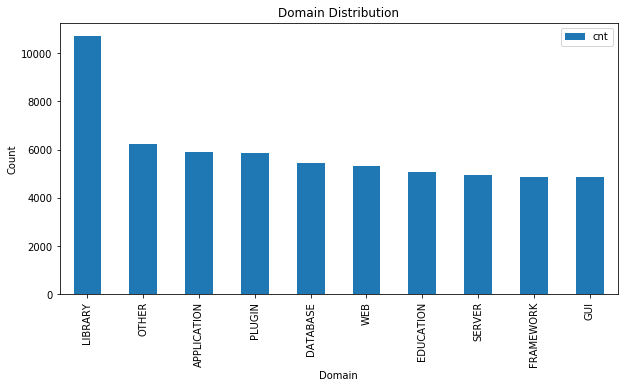

In [12]:
domain = spark.sql("""
SELECT domain_name, count(1) cnt
FROM diversity
GROUP BY domain_name
ORDER BY cnt DESC
""").toPandas()
f1 = domain.plot(kind="bar", x="domain_name", y="cnt", figsize=(10,5))
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.savefig(os.path.join('domain.png'), dpi=300, format='png', bbox_inches='tight') 

- Select top 20 frequent languages and visualization in bar graph as following. Javascript is the most popular language with over 10000 records in this dataset. JAVA, Python, Ruby and PHP are also really popular according to the result.

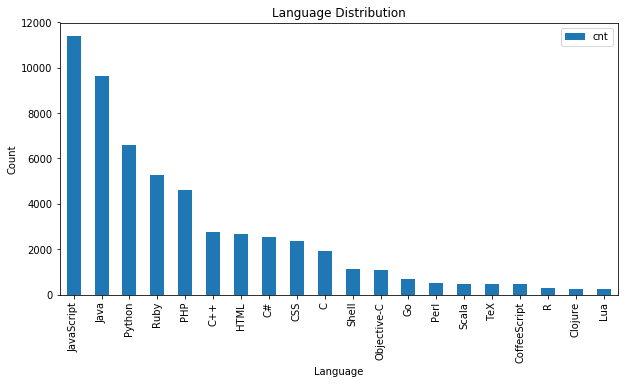

In [13]:
language = spark.sql("""
SELECT language, count(1) cnt
FROM diversity
GROUP BY language
ORDER BY cnt DESC
LIMIT 20
""").toPandas()
f2= language.plot(kind="bar", x="language", y="cnt", figsize=(10,5))
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Count")
plt.savefig(os.path.join('language.png'), dpi=300, format='png', bbox_inches='tight') 

## Data Preparation
In this part, we calculate the versatility of domain and language of individual and team in GitHub respectively based on the concept of versatility of interest proposed in the core paper. 
### Import Packages

In [1]:
from pyspark.sql import *
import pyspark.sql.types as T 
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import math
import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline  

### Import dataset as RDD in spark
Import project_processed.csv and mem_commits.csv(commits number of each user) and create Tempview.

In [2]:
# Import processed project data as RDD
diversity_data = sc.textFile("project_processed.csv").filter(lambda line: not line.startswith("pid"))

In [3]:
# Seperate different columns in eahc row by comma
diversity_Fields = diversity_data.map(lambda line: line.split(","))

In [4]:
# Attach header of each column
diversity_Rows = diversity_Fields.map(lambda x: Row( pid = x[0],
                                              name = x[1],
                                              domain = x[2],
                                              language = x[3],
                                            total_commits = x[4],
                                            total_number = x[5],
                                            team = x[6].split(" ")
                                            )
                             )

In [5]:
diversity_Rows.count()

59244

In [6]:
# Create Dataframe based on diversity_Rows
diversityDF = spark.createDataFrame(diversity_Rows)

In [7]:
diversityDF.printSchema()

root
 |-- domain: string (nullable = true)
 |-- language: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pid: string (nullable = true)
 |-- team: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- total_commits: string (nullable = true)
 |-- total_number: string (nullable = true)



In [8]:
diversityDF.show()

+------+--------+--------------------+--------+--------------------+-------------+------------+
|domain|language|                name|     pid|                team|total_commits|total_number|
+------+--------+--------------------+--------+--------------------+-------------+------------+
|   1.0|       C|             Droplit|10723367|[1053835, 457765,...|           26|           5|
|   5.0|       C|                MOAG| 9690090|[3954487, 393108,...|          103|           5|
|   6.0|       C|                PKSM|51048186|[34569796, 108730...|          615|           5|
|   6.0|       C|       coral-calcium|  328395|[191533, 191524, ...|          127|           7|
|   1.0|       C|           tarantool| 4397024|[44189, 280576, 1...|        13449|          17|
|   2.0|       C|spideroak_inotify...|10572384|[10478, 15055, 96...|           16|          18|
|   4.0|       C|            dablooms|     236|[1783, 1054072, 1...|           62|          33|
|   0.0|       D|    media-unofficial|  

In [9]:
diversityDF.createOrReplaceTempView("diversity")

In [10]:
# Read the commits number of each user as RDD
member_commits = sc.textFile("mem_commits.csv").filter(lambda line: not line.startswith("user_id"))

In [11]:
# Seperate different columns in eahc row by comma
member_Fields = member_commits.map(lambda line: line.split(","))

In [12]:
# Attach header of each column
member_Rows = member_Fields.map(lambda x: Row( user_id = x[0],
                                              commits_num = int(x[1])
                                            )
                             )

In [13]:
memberDF = spark.createDataFrame(member_Rows)

In [14]:
memberDF.printSchema()

root
 |-- commits_num: long (nullable = true)
 |-- user_id: string (nullable = true)



In [15]:
memberDF.createOrReplaceTempView("mem_commits")

### Create users schema
In the core paper, Baraniak et al proposed a way to calcualte the versatility of interest in terms of Wikipedia projects[1]. The Versatility represents the entropy of editor's partial contributions to each category. And the productivity represents the number of bytes by which they modified Wikipedia content. In order to migrate this Wikipedia-based approach to GitHub dataset, I select Domain versatility, Language Versatility and Commits to analyze. Since The domain and language of projects could also reflect the interest versatility of GitHub user. And Commits could be a good feature to quantify the productivity of GitHub teams.


Calculate the entropy of domain diversity and language diversity for each team member.
- Rebuild the data structure by exploding team and group by uid
- Calculate the percent of each domain/language according to each user
- Calculate the entropy by $ V(x) = \sum_i{-p_i log_2(p_i)} $, where $p_i$ is the percent of each domain/language

In [16]:
# Explode the team and calcualte the domain versatility
spark.sql("""
SELECT uid, SUM(-domain_per * LOG(domain_per)/LOG(2)) domain_vers 
FROM(
    SELECT DISTINCT uid, domain, COUNT(1) over (partition by uid, domain) / COUNT(1) over (partition by uid) domain_per
    FROM (
        SELECT pid, domain, language, explode(team) uid FROM diversity
    )
    
    order by uid
)
GROUP BY uid
""").createOrReplaceTempView("domain_vers")

In [17]:
# Explode the team and calcualte the language versatility
spark.sql("""
SELECT uid, SUM(-language_per * LOG(language_per)/LOG(2)) language_vers 
FROM(
    SELECT DISTINCT uid, language, COUNT(1) over (partition by uid, language) / COUNT(1) over (partition by uid) language_per
    FROM (
        SELECT pid, language, explode(team) uid FROM diversity
    )
    order by uid
)
GROUP BY uid
""").createOrReplaceTempView("language_vers")

In [18]:
# Join the domain versatility and language versatility based on uid
users_vers = spark.sql("""
SELECT uid, domain_vers, language_vers, commits_num
FROM(
SELECT uid, domain_vers, language_vers 
    FROM(
    SELECT * FROM (
        SELECT uid domain_uid, domain_vers FROM domain_vers
    ) t JOIN language_vers ON t.domain_uid = language_vers.uid
)
ORDER BY uid
) p 
INNER JOIN mem_commits ON p.uid = mem_commits.user_id
""")

In [19]:
users_vers.createOrReplaceTempView("users_vers")

In [20]:
users_vers.show()

+--------+-----------------+------------------+-----------+
|     uid|      domain_vers|     language_vers|commits_num|
+--------+-----------------+------------------+-----------+
|  100227|1.584962500721156| 1.584962500721156|      11502|
|  100768|1.584962500721156|0.9182958340544896|       4662|
| 1009080|              0.0|               0.0|       1200|
|  101021|              0.0|               0.0|      50259|
| 1014157|              0.0|               0.0|      10095|
|10167090|              0.0|               0.0|          6|
|10205737|              0.0|               0.0|        429|
|10206095|              0.0|               0.0|         21|
|10206130|              0.0|               0.0|          2|
|10209666|              0.0|               0.0|         39|
| 1020987|              0.0|               0.0|        295|
|10232587|              0.0|               0.0|         34|
| 1024606|              0.0|               0.0|       1332|
|  102539|1.584962500721156|            

### Create project_vers schema
Calculate the average diversity of domain and language of the projects based on each team member's diversity, and save to project_vers.csv.

In [21]:
# Calcualte the domain versatility and team varsatiltiy
project_vers = spark.sql("""
SELECT pid, name, total_number team_size, total_commits, total_commits/total_number per_commits, AVG(domain_vers) domain_vers, AVG(language_vers) language_vers 
FROM (
SELECT pid, name, total_commits, total_number, explode(team) uid
FROM diversity
) d JOIN users_vers ON d.uid = users_vers.uid

GROUP BY pid, name, team_size, total_commits, per_commits
ORDER BY pid
""")

In [22]:
project_vers.createOrReplaceTempView("project_vers")

In [23]:
project_vers.show()

+--------+--------------------+---------+-------------+------------------+-------------------+-------------------+
|     pid|                name|team_size|total_commits|       per_commits|        domain_vers|      language_vers|
+--------+--------------------+---------+-------------+------------------+-------------------+-------------------+
|     100|        angular-seed|       20|          162|               8.1| 2.5659908484171225| 1.2751919210453853|
|10000062|          luvit-tape|        5|           50|              10.0|  2.919631798648272| 1.7272840454193108|
|10000113| jQuery-rwdImageMaps|        8|           14|              1.75|  0.771240625180289| 0.1147869792568112|
|10000302|WordPress-iOS-Editor|       15|          739|49.266666666666666| 3.1903972574439887|  2.059837422350975|
|10000717|fluxx_api_toolkit...|       24|           20|0.8333333333333334|0.06559255957532069|0.11321160719436829|
|10000731|             samples|       22|           30|1.3636363636363635| 0.158

In [24]:
project_vers.toPandas().to_csv('project_vers.csv', index = False, header = True)

## Modeling
### Analysis of Editor's Productivity and Versatility
- Seperate feature total_commits into 5 categories: A(total_commits < 1000), B(1000<=total_commits<2000), C(2000<=total_commits<3000), D(3000<=total_commits<5000), E(5000<=total_commits<10000),F(total_commits>10000)
- Analyzed five groups of editors and denoted them in boxplot graphs: the result for domain versatility is presented on left and language versatility is presented on right.
- From the graph, we could observe a slight increasing in versatility when user's productivity add up from level A to level F. It is indicates that there might be a positive correlation between user's domain/language versatility and user's productivity.

In [29]:
# Seperate total_commits into five categories
users_vers_pro = spark.sql("""
SELECT uid, domain_vers, language_vers, 
CASE WHEN commits_num < 1000 THEN 'A'
WHEN commits_num >= 1000 AND commits_num < 2000 THEN 'B'
WHEN commits_num >= 2000 AND commits_num < 3000 THEN 'C'
WHEN commits_num >= 3000 AND commits_num < 5000 THEN 'D'
WHEN commits_num >= 5000 AND commits_num < 10000 THEN 'E'
WHEN commits_num >= 10000 THEN 'F'
END AS productivity
FROM users_vers
""")

In [30]:
users_vers_pro.createOrReplaceTempView("users_vers_pro")

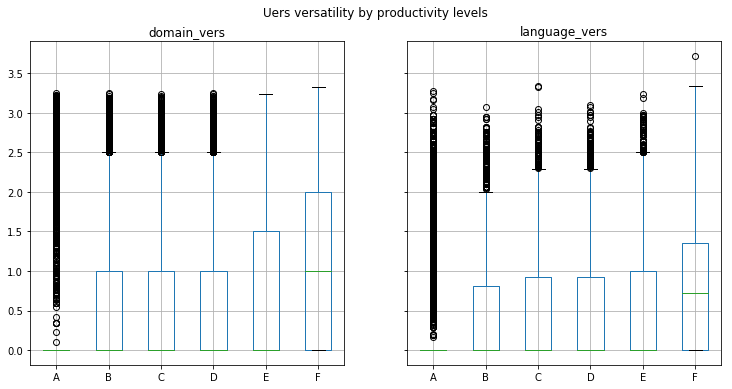

In [31]:
# Plot boxplot of five categories of productivity and corresponding domain versatility and language versatility.
bp = users_vers_pro.toPandas().boxplot(by='productivity', figsize=(12,6))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Uers versatility by productivity levels')
plt.show()

In [32]:
spark.sql("""
SELECT productivity, COUNT(1) cnt, AVG(domain_vers) domain_vers_avg, AVG(language_vers) language_vers_avg
FROM users_vers_pro

GROUP BY productivity
ORDER BY productivity

""").show()

+------------+------+------------------+-------------------+
|productivity|   cnt|   domain_vers_avg|  language_vers_avg|
+------------+------+------------------+-------------------+
|           A|160147|0.2337085076642322|0.16029239239985488|
|           B| 21784|0.4754517293078308|0.32245284431419446|
|           C| 11940|0.5548705775313284| 0.3752255224312286|
|           D| 13834|0.6263895049087452|   0.41936311225969|
|           E| 16037|0.7330170125686415|0.49278561777226876|
|           F| 38281| 1.166505228422436|  0.738431739565536|
+------------+------+------------------+-------------------+



### Applying Linear Regression model on teams
- In this experiment, analyze the relationship between the diversity of team and the productivity of team.
- Apply Linear Regression model on small project(teamsize < 11), medium project(11<=teamsize<50), and large project(teamsize>50). In the core paper, the response variable is categorical feature: quality of the Wikipedia articles. 0 represents the normal articles while 1 represents featured/good articles. Since there isn't a clear standard for the productivity of the project. So I selected linear regression instead of logistic regression to analyze the relationship between the diversity of team in Github and their productivity. 
- Therefore, domain versatility and language versatility are selected as features and per_commits is response variable.

In [33]:
project_vers = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("project_vers.csv"))\
   .dropna()

In [34]:
project_vers.createOrReplaceTempView("project_vers")

In [35]:
results = []

In [36]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

def model(team_type, data, module):
    
    vectorAssembler = VectorAssembler(inputCols = ['domain_vers','language_vers'], outputCol = 'features')
    vers = vectorAssembler.transform(data)
    vers = vers.select(['features', 'per_commits'])
    
    splits = vers.randomSplit([0.7, 0.3], seed = 101)
    train = splits[0]
    test = splits[1]

    model = module.fit(train)
    
    trainingSummary = model.summary
    
    lr_predictions = model.transform(test)   
    test_result = model.evaluate(test)

    
    result = {'type': team_type, 'model': module, 
              'Coefficients':model.coefficients, 'Intercept':model.intercept,
              'train_RMSE':trainingSummary.rootMeanSquaredError, 
              'test_RMSE':test_result.rootMeanSquaredError }
    
    results.append(result)  

In [37]:
small_team = spark.sql("""
SELECT * FROM project_vers
WHERE team_size < 11
""")

In [38]:
medium_team = spark.sql("""
SELECT * FROM project_vers
WHERE (team_size >= 11 AND team_size < 50)
""")

In [39]:
large_team = spark.sql("""
SELECT * FROM project_vers
WHERE team_size > 50
""")

In [40]:
# Build the linear regression modle and apply to three dataset
from pyspark.ml.regression import LinearRegression
lr = LinearRegression( featuresCol = 'features', labelCol='per_commits', maxIter=10, regParam=0.3, elasticNetParam=0.8)
model("small_team", small_team, lr)
model("medium_team", medium_team, lr)
model("large_team", large_team, lr)

In [41]:
# Show the results
col = ['type','model','Coefficients','Intercept','train_RMSE','test_RMSE']
pd.DataFrame.from_dict(results)[col]

,type,model,Coefficients,Intercept,train_RMSE,test_RMSE
0,small_team,LinearRegression_4924bc6cea17ed425371,"[3.730176678246042, 2.090636085447597]",47.873306,230.220384,194.357750
1,medium_team,LinearRegression_4924bc6cea17ed425371,"[-0.7141944373278759, -1.6987954758988302]",48.664503,191.990099,223.458552
2,large_team,LinearRegression_4924bc6cea17ed425371,"[-7.605424938512877, 3.139847160775286]",27.378889,89.431752,47.673887


## Results Interpretations
### Analysis of individual's Productivity and Versatility
A boxplot is a standardized way of displaying the distribution of data based on a five number summary (minimum, first quartile, median, third quartile, and maximum). In this experiment, we use boxplot to visualize the relationship between Versatility and productivity. The result for domain versatility is shown on left while language versatility is shown on right. In both graph, we could notice a positive connection between versatility and the productivity of the user. In general, more versatility the user are, he or she will be more productive. Also by comparing two graph, we can notice that language versatility seems to have a stronger connection with productivity than domain versatility.
### Applying Linear Regression model on Team Versatility
We apply linear regression to analyze the relationship between the versatility and productivity of GitHub repositories. We also separate the repositories into three different categories: small(means project members are less than 11), medium(means project member are between 11 to 50), and large(means project members are over 50). We could observe that Root Mean Square Deviation(RMSD, a measure of the differences between values predicted by a model or an estimator and the values observed) is decreasing while the size of group increasing. We could speculate that as group size increasing, the team versatility will also increase and lead to a higher productivity. However, We need to admit that the result model is not ideal for predicting productivity, since the collaboration among Wikipedia projects and collaboration among GitHub projects might have different mechanism and characteristics. 

For Wikipedia editor, high diversity of interest reflects the editor's erudite and passion for Wikipedia editing work. Diverse knowledge and familiar collaboration could help editors develop high quality Wikipedia articles. As Baraniak mentioned in the core paper[1], user with broader expertise might act as ties between community subgroups, which is a crucial factor for maintaining a group coherence.

However for Github user, commit to different domain of projects or different language of projects has no strong relation to their work quality. For Github users, an expertise in a specific domain turns to be more productive than users who has been involved into many fields. 

## Conclusion

- There are still some place to improve in the future:
    - Other than domain versatility and language versatility, other diversity feature like gender, location or tenure could be take into consideration. 
    - The dataset ght_2018_04_01 provided by GHTorrent is not complete. Therefore, I doubt that the faults and incompletency of dataset might affect the result of the experiments. A better dataset should be selected for analyzation in the futre.
        - In users table, no user is created in year 2010, 2014, 2015, 2016.
        - In projects table, no project is updated in year 2018
        - etc
               
   

## Reference

[1] M. Sydow, K. Baraniak, and P. Teisseyre, “Diversity of editors and teams versus quality of cooperative work: experiments on wikipedia,” Journal of Intelligent Information Systems, vol. 48, no. 3, pp. 601–632, jun 2017. [Online]. Available: http://link.springer.com/10.1007/s10844-016-0428-1

[2] Vasilescu, B., Serebrenik, A., & Filkov, V. (2015). A Data Set for Social Diversity Studies of GitHub Teams. In 2015 IEEE/ACM 12th Working Conference on Mining Software Repositories (pp. 514–517). IEEE. https://github.com/bvasiles/diversity

[3] B. Ray, D. Posnett, V. Filkov, and P. Devanbu, “A large scale study of programming languages and code quality in github,” in Proceedings of the 22nd ACM SIGSOFT International Symposium on Foundations of Software Engineering - FSE 2014. New York, New York, USA: ACM Press, 2014, pp. 155–165. [Online]. Available: http://dl.acm.org/citation.cfm?doid=2635868.2635922

[4] G. Georgios, “The GHTorent dataset and tool suite,” Proceedings of the 10th Working Conference on Mining Software Repositories, p. 438, 2013. [Online]. Available: https://dl.acm.org/citation.cfm?id=2487132

[5] Grewal, Rajdeep et al. “Location, Location, Location: How Network Embeddedness Affects Project Success in Open Source Systems.” Management Science 52 (2006): 1043-1056.




